In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
34,application_1606998977104_0001,pyspark,idle,Link,Link


SparkSession available as 'spark'.

In [2]:
import hsfs
# Create a connection
connection = hsfs.connection()
# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

In [3]:
edge_fg = fs.get_feature_group("edge_features", 1)

In [4]:
source = edge_fg.select(["source","is_sar"]).read().withColumnRenamed("source","id")
target = edge_fg.select(["target","is_sar"]).read().withColumnRenamed("target","id")
nodes = source.union(target)

In [5]:
ano_nodes = nodes.where(nodes.is_sar == 1)
ben = nodes.where(nodes.is_sar == 0)
ben_nodes = ben.join(ano_nodes, ["id"], "leftanti")
labels = ano_nodes.union(ben_nodes).dropDuplicates(subset=["id"])

In [6]:
labels.count()

9998

In [7]:
df = spark.read.csv("hdfs:///Projects/amlsim/Resources/embeddings_features_80_5_128.csv",inferSchema=True,header=True)

In [8]:
feature_names = df.columns
feature_names = ["_" + s + "c"  for s in feature_names]

In [9]:
df = df.toDF(*feature_names)

In [10]:
feature_names = df.columns
print(feature_names)

['__c0c', '_0c', '_1c', '_2c', '_3c', '_4c', '_5c', '_6c', '_7c', '_8c', '_9c', '_10c', '_11c', '_12c', '_13c', '_14c', '_15c', '_16c', '_17c', '_18c', '_19c', '_20c', '_21c', '_22c', '_23c', '_24c', '_25c', '_26c', '_27c', '_28c', '_29c', '_30c', '_31c', '_32c', '_33c', '_34c', '_35c', '_36c', '_37c', '_38c', '_39c', '_40c', '_41c', '_42c', '_43c', '_44c', '_45c', '_46c', '_47c', '_48c', '_49c', '_50c', '_51c', '_52c', '_53c', '_54c', '_55c', '_56c', '_57c', '_58c', '_59c', '_60c', '_61c', '_62c', '_63c', '_64c', '_65c', '_66c', '_67c', '_68c', '_69c', '_70c', '_71c', '_72c', '_73c', '_74c', '_75c', '_76c', '_77c', '_78c', '_79c', '_80c', '_81c', '_82c', '_83c', '_84c', '_85c', '_86c', '_87c', '_88c', '_89c', '_90c', '_91c', '_92c', '_93c', '_94c', '_95c', '_96c', '_97c', '_98c', '_99c', '_100c', '_101c', '_102c', '_103c', '_104c', '_105c', '_106c', '_107c', '_108c', '_109c', '_110c', '_111c', '_112c', '_113c', '_114c', '_115c', '_116c', '_117c', '_118c', '_119c', '_120c', '_121c', '_

In [11]:
feature_names[0]= 'id'

In [12]:
node_embeddings = df.toDF(*feature_names)

In [25]:
from hops import hdfs
import pandas 
node_path = "hdfs:///Projects/amlsim/Resources/node_embeddings_for_plotting.csv"
node_embeddings = hdfs.get_plain_path([path for path in hdfs.ls(node_path) if path.endswith("csv")][0])

labels_path = "hdfs:///Projects/amlsim/Resources/node_labels_for_plotting.csv"
labels = hdfs.get_plain_path([path for path in hdfs.ls(labels_path) if path.endswith("csv")][0])
labels

'/Projects/amlsim/Resources/node_labels_for_plotting.csv/part-00000-adb9656d-a865-4da2-a42f-23ac3f2eca52-c000.csv'

In [16]:
node_embeddings.coalesce(1)\
      .write\
      .option("header","true")\
      .option("sep",",")\
      .mode("overwrite")\
      .csv("hdfs:///Projects/amlsim/Resources/node_embeddings_for_plotting.csv")
    
labels.coalesce(1)\
      .write\
      .option("header","true")\
      .option("sep",",")\
      .mode("overwrite")\
      .csv("hdfs:///Projects/amlsim/Resources/node_labels_for_plotting.csv")

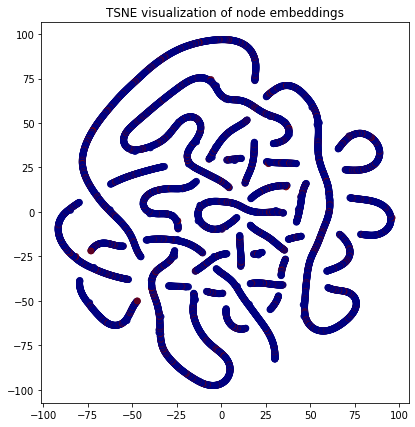

In [27]:
%%local
%matplotlib inline 
import pandas 
import matplotlib.pyplot as plt
import pandas as pd
from hops import hdfs
import pydoop.hdfs as pydoop

from sklearn.manifold import TSNE
transform = TSNE  # PCA

node_path = "hdfs:///Projects/amlsim/Resources/node_embeddings_for_plotting.csv"
node_embeddings = pandas.read_csv(pydoop.path.abspath(hdfs.get_plain_path([path for path in hdfs.ls(node_path) if path.endswith("csv")][0])))

labels_path = "hdfs:///Projects/amlsim/Resources/node_labels_for_plotting.csv"
labels = pandas.read_csv(pydoop.path.abspath(hdfs.get_plain_path([path for path in hdfs.ls(labels_path) if path.endswith("csv")][0])))


trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = pd.Series(labels.is_sar.values,index=labels.id).to_dict()

node_colours = []
for target in node_embeddings.id.values:
    if target in label_map:
        node_colours.append(label_map[target])
    else:
        node_colours.append(0)
        
plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

node_embeddings = node_embeddings.toPandas()
labels = labels.toPandas()
from sklearn.manifold import TSNE
transform = TSNE  # PCA
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = pd.Series(labels.is_sar.values,index=labels.id).to_dict()

node_colours = []
for target in node_embeddings.id.values:
    if target in label_map:
        node_colours.append(label_map[target])
    else:
        node_colours.append(0)
        
plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
#plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.savefig("tsne.pdf")
plt.close()

from hops import hdfs
hdfs.copy_to_hdfs('tsne.pdf', "Resources", overwrite=True, project="amlsim")

Started copying local path tsne.pdf to hdfs path hdfs://rpc.namenode.service.consul:8020/Projects/amlsim/Resources/tsne.pdf

Finished copying

In [9]:
from hops import featurestore

featurestore.create_featuregroup(
    df,
    "embeddings_features",
    description="embeddings features",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featurestore=featurestore.project_featurestore(),
    featuregroup_version= featurestore.get_latest_featuregroup_version("embeddings_features") + 1       
)


Registering feature metadata...
Registering feature metadata... [COMPLETE]
Writing feature data to offline feature group (Hive)...
Running sql: use paysim_featurestore against offline feature store
Writing feature data to offline feature group (Hive)... [COMPLETE]
Feature group created successfully

In [11]:
from hops import featurestore
nodes = featurestore.get_featuregroup("node_features", featuregroup_version= featurestore.get_latest_featuregroup_version("node_features"))


nodes.show()

Running sql: use paysim_featurestore against offline feature store
SQL string for the query created successfully
Running sql: SELECT * FROM node_features_2 against offline feature store
+-----+--------+----+
|label|      id|type|
+-----+--------+----+
|    0|be48fd21|   0|
|    0|74a25898|   0|
|    1|a7dbdccf|   0|
|    1|a0dd1711|   0|
|    1|21e606f8|   0|
|    1|0d85d2da|   0|
|    0|a4ca0025|   2|
|    0|e49d5b08|   2|
|    0|b3cb9431|   0|
|    1|e9f40a65|   0|
|    1|915129a1|   0|
|    1|54e41f37|   0|
|    1|238bcb74|   0|
|    1|75af7fb0|   0|
|    0|1094e145|   0|
|    0|439a40f9|   0|
|    0|dbce3268|   0|
|    1|96e4b8ea|   0|
|    0|3df2fa55|   2|
|    0|225130db|   2|
+-----+--------+----+
only showing top 20 rows

In [12]:
nodes.printSchema()

root
 |-- label: string (nullable = true)
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)

In [13]:
embeddings_td = df.join(nodes.drop('type'),on='id')
embeddings_td.count()

460

In [14]:
from pyspark.sql import functions as func
from pyspark.sql.types import IntegerType
embeddings_td = embeddings_td.withColumn("label" , func.col("label").cast(IntegerType()))

In [15]:
embeddings_td.printSchema()

root
 |-- id: string (nullable = true)
 |-- _0c: double (nullable = true)
 |-- _1c: double (nullable = true)
 |-- _2c: double (nullable = true)
 |-- _3c: double (nullable = true)
 |-- _4c: double (nullable = true)
 |-- _5c: double (nullable = true)
 |-- _6c: double (nullable = true)
 |-- _7c: double (nullable = true)
 |-- _8c: double (nullable = true)
 |-- _9c: double (nullable = true)
 |-- _10c: double (nullable = true)
 |-- _11c: double (nullable = true)
 |-- _12c: double (nullable = true)
 |-- _13c: double (nullable = true)
 |-- _14c: double (nullable = true)
 |-- _15c: double (nullable = true)
 |-- _16c: double (nullable = true)
 |-- _17c: double (nullable = true)
 |-- _18c: double (nullable = true)
 |-- _19c: double (nullable = true)
 |-- _20c: double (nullable = true)
 |-- _21c: double (nullable = true)
 |-- _22c: double (nullable = true)
 |-- _23c: double (nullable = true)
 |-- _24c: double (nullable = true)
 |-- _25c: double (nullable = true)
 |-- _26c: double (nullable = true)

In [17]:
featurestore.create_training_dataset(
    embeddings_td, "embeddings_training_dataset",
    descriptive_statistics=False,
    feature_correlation=False,
    feature_histograms=False,
    cluster_analysis=False,
    featurestore=featurestore.project_featurestore(),
    training_dataset_version=featurestore.get_latest_training_dataset_version("embeddings_training_dataset") + 1
)


Could not infer tfrecords schema for the dataframe, module 'tensorflow' has no attribute 'VarLenFeature'
write feature frame, write_mode: overwrite
Training Dataset created successfully